In [ ]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [ ]:
def gen_finite_elements(H: float = 6, # высота детали
                        W: float = 5, # длина детали
                        R: float = 1, # радиус вырезов, а также длина участков 1 и 2
                        nb: int = 10,   # количество узлов на участке границы
                        nm: float = 20, # количество внутренних узлов
                        delta: float = 0.2, # отступ от границы
                       ):
  '''
  Генерирует узлы и треугольные конечные элементы для детали определенной формы.
  '''
  G1x = np.linspace(0, R, int(nb/2), endpoint = False)
  G1y = np.zeros_like(G1x)
  G6y = np.linspace(H-R, H, int(nb/2), endpoint = False)
  G6x = np.zeros_like(G6y) + W
  G3x = np.linspace(3*R, W, nb, endpoint = False)
  G3y = np.zeros_like(G3x)
  G4y = np.linspace(0, H-3*R, nb, endpoint = False)
  G4x = np.zeros_like(G4y) + W
  G7x = np.linspace(W, 0, nb, endpoint = False)
  G7y = np.zeros_like(G7x) + H
  G8y = np.linspace(H, 0, nb, endpoint = False)
  G8x = np.zeros_like(G8y)

  alpha = np.radians(np.linspace(180, 0, nb, endpoint = False))

  G2x = 2*R + R * np.cos(alpha)
  G2y = R * np.sin(alpha)

  alpha = np.radians(np.linspace(270, 90, nb, endpoint = False))
  G5x = W + R * np.cos(alpha)
  G5y = H - 2*R + R * np.sin(alpha)

    
  GNodes = \
  np.column_stack((
  np.row_stack((G1x, G1y)),
  np.row_stack((G2x, G2y)),
  np.row_stack((G3x, G3y)),
  np.row_stack((G4x, G4y)),
  np.row_stack((G5x, G5y)),
  np.row_stack((G6x, G6y)), 
  np.row_stack((G7x, G7y)),
  np.row_stack((G8x, G8y))
  )).T
    
  x,y = np.mgrid[delta:W-delta:nm*1j, delta:H-delta:nm*1j]
  INodes = np.column_stack((x.ravel(), y.ravel()))
    
  p = Path(GNodes, closed=True)
  mask = p.contains_points(INodes, radius=-delta)
    
  INodes = INodes[mask]
    
  Nodes = np.vstack((GNodes, INodes))
  tri = Delaunay(Nodes)
  Elems = tri.simplices.copy()
    
  Coords = Nodes[Elems]
  centers = Coords.mean(axis=1)
  emask = p.contains_points(centers)
  Elems = Elems[emask]

  #plt.plot(*GNodes.T, '.k')
  #plt.fill(*GNodes.T)
  #plt.axis('equal')

  plt.figure(figsize=(10, 10))
  for i in range(GNodes.shape[0]):
    plt.text(*GNodes[i], f"{i}")
  plt.triplot(*Nodes.T, Elems)
  plt.axis('equal')
    
  return Nodes, Elems, GNodes.shape[0]

In [ ]:
def gen_stiffness_matrix(Nodes, Elems, E, mu, t):
  '''
  Генерирует матрицу жесткости
  '''
  Coords = Nodes[Elems]
  b = Coords[:,[1, 2, 0],1] - Coords[:,[2, 0, 1],1]
  c = Coords[:,[2, 0, 1],0] - Coords[:,[1, 2, 0],0]
  v = Coords[:, [1, 2]] - Coords[:, [0, 0]]
  A = 0.5 * np.cross(v[:,0], v[:,1], axis=1) # площадь
  z = np.zeros(Coords.shape[0])
  B0 = np.column_stack((b[:,0], z, b[:,1], z, b[:,2], z))
  B1 = np.column_stack((z, c[:,0], z, c[:,1], z, c[:,2]))
  B2 = np.column_stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]))
  B = np.stack((B0, B1, B2), axis=2).transpose((0, 2, 1)) / (2*A.reshape(-1,1,1)) # матрица градиентов
    
  D = E / (1 - mu**2) * np.array([[1, mu, 0],
                                  [mu, 1, 0],
                                  [0,  0, (1 - mu)/2]]) # матрица упругих характеристик
  Ve = A * t # объемы элементов
  Ke = (B.transpose((0, 2, 1)) @ D @ B) * Ve[:,None,None] # локальная матрица жесткости
  EFT = np.repeat(Elems*2, 2, axis=1)
  EFT[:, [1, 3, 5]] += 1
    
  N, M = Nodes.shape[0], Elems.shape[0]
  K = np.zeros((2*N, 2*N))
  for e in range(M):
      p = EFT[e, None].T
      q = EFT[e]
      K[p, q] += Ke[e] # глобальная матрица жесткости
        
  return K, B, EFT, A, D

In [ ]:
def freedom(nodes_idx, prj='x'):
  '''
  Возвращает степени свободы узлов в заданной проекции
  '''
  arr = np.array(nodes_idx)
  if prj == 'x':
      return arr * 2
  elif prj == 'y':
      return arr * 2 + 1
  elif prj == 'xy':
      return np.column_stack((arr * 2, arr * 2 + 1))
    
  raise ValueError(f'Need prj "x", "y" or "xy", got {prj}')

In [ ]:
def zero_displacement(K, F, dof):
  '''
  Зануляет перемещения закрепленных узлов
  '''
  K[dof] = 0
  K[:,dof] = 0
  K[dof,dof] = 1
  F[dof] = 0
  return K, F

In [ ]:
def surface_stress(F, Nodes, nodes_idx, t, p):
  '''
  Расчитывает распределенное на всю деталь усилие 
  '''
  n1, n2 = Nodes[nodes_idx[:2]]
  l12 = np.linalg.norm(n2 - n1)
  S12 = l12 * t
  dof = freedom(nodes_idx, 'xy')
  f = np.zeros((nodes_idx.shape[0], 2))
  f += 0.5 * S12 * p
  f[1:-1] *= 2
  F[dof] = f
  return F

In [ ]:
def node_stress_eigvals(Elems, EFT, U, B, A, D):
  '''
  Расчитывает напряжения в каждом узле детали
  '''
  Eps = B @ U[EFT, None] # тензор деформаций
  Sig = D @ Eps # тензор напряжений
    
  N = U.shape[0] // 2
  SigN = np.zeros((N, 3))
  for n in range(N):
      mask = np.any(Elems == n, axis=1)
      Ae = A[mask]
      SigN[n] = Ae @ Sig[mask, : ,0] / np.sum(Ae) # тензор напряжения в узле
        
  sq = ((SigN[:,0] - SigN[:,1])**2+4*SigN[:,2]**2)**0.5
  su = SigN[:,0] + SigN[:,1]
  SN = 0.5*np.column_stack((su + sq, su - sq)) # собственные значения тензора напряжений
  return SN

In [ ]:
def Smax(P, Nodes, Elems, E, mu, t, nb):
  '''
  Расчитывает максимальное по модулю напряжение при заданной величине усилия
  '''
  K, B, EFT, A, D = gen_stiffness_matrix(Nodes, Elems, E, mu, t)

  F = np.zeros(2*Nodes.shape[0])
  b2l = int(nb/2) + 4*nb
  b2r = b2l + int(nb/2) + 1;
  dof = np.hstack(freedom(np.arange(b2l, b2r), prj='xy').ravel())

  K, F = zero_displacement(K, F, dof)

  alpha = np.radians(120)
  p = P * np.array([np.cos(alpha), np.sin(alpha)])

  F = surface_stress(F, Nodes, np.arange(0, int(nb/2) + 1), t, p)

  U = np.linalg.solve(K, F)

  SN = node_stress_eigvals(Elems, EFT, U, B, A, D)

  Smax = np.max(np.abs(SN))

  return Smax

**Вариант 10**

Деталь D с размерами R, H, W = 1, 6, 5 см и толщиной 6 см подвержена упругой деформации посредством приложения к зоне 1 равномерно распределенного усилия P (кг), действующую под углом 120 градусов. Зона 2 неподвижна. Определить наибольшее смещение детали U (см) при условии сохранения упругой деформации, если деталь изготовлена из стали №3 ($E = 220$ ГПа, $\mu = 0.31$, $\sigma_T = 900$ МПа).

In [ ]:
# константы
E = 220e9 # модуль Юнга
mu = 0.31 # коэффициент Пуассона
sigma_T = 900e6 # предел текучести при растяжении
t = 6 # толщина
nb = 12 # количество точек разбиения

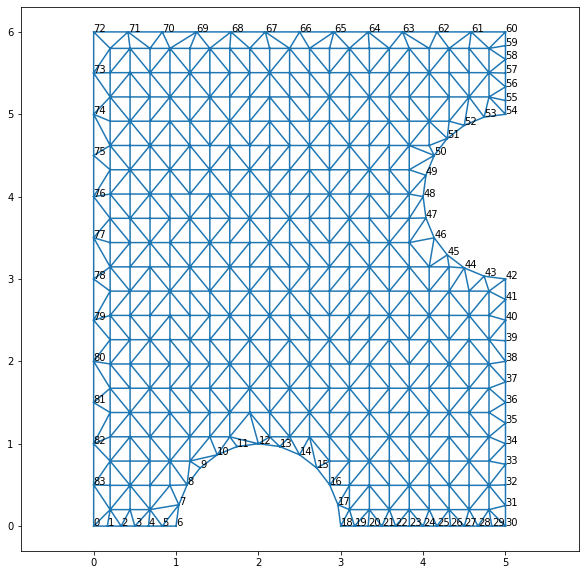

In [ ]:
Nodes, Elems, Nb = gen_finite_elements(nb = nb) # генерируем разбиение

In [ ]:
#задаем начальные догадки для метода дихотомии
Plow = 1e7;
print(Smax(Plow, Nodes, Elems, E, mu, t, nb) < sigma_T)
Phigh = 1e8;
print(Smax(Phigh, Nodes, Elems, E, mu, t, nb) > sigma_T)

True
True


In [ ]:
tol = 1e-4 # точность вычислений

#методом дихотомии ищем критическое значение P

while (Phigh-Plow)/2 >= tol:
  Pmid = (Plow + Phigh) / 2;
  Smid = Smax(Pmid, Nodes, Elems, E, mu, t, nb)
  if Smid < sigma_T:
    Plow = Pmid
  if Smid > sigma_T:
    Phigh = Pmid

In [ ]:
# проверяем результат
print(Smax(Plow, Nodes, Elems, E, mu, t, nb))
print(Smax(Phigh, Nodes, Elems, E, mu, t, nb))

899999999.9985361
900000000.0038154


In [ ]:
lgP = np.linspace(0, 8, 100);
P = 10**lgP;
SP = np.zeros(100)
for i in range(100):
  SP[i] = Smax(P[i], Nodes, Elems, E, mu, t, nb)

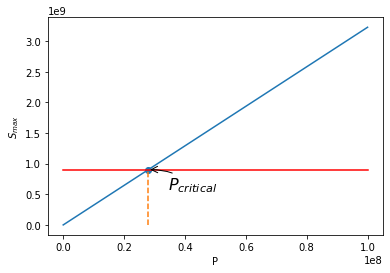

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot(P, SP)
Popt = Plow;
Sopt = Smax(Plow, Nodes, Elems, E, mu, t, nb);

ax1.plot([Popt, Popt], [0, Sopt], linestyle = '--');
ax1.scatter([Popt, ], [Sopt, ])
ax1.annotate(r'$P_{critical}$',
             xy=(Popt, Sopt), xycoords='data',
             xytext=(+20, -20), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
ax1.plot([0, 1e8], [sigma_T, sigma_T], color = 'red')
ax1.set_ylabel(r'$S_{max}$')
ax1.set_xlabel(r'P')
plt.show()

In [ ]:
Psolve = Plow

In [ ]:
 #генерируем матрицу жесткости
 K, B, EFT, A, D = gen_stiffness_matrix(Nodes, Elems, E, mu, t)

In [ ]:
#задаем таблицу степеней свободы для границы 2
F = np.zeros(2*Nodes.shape[0])
b2l = int(nb/2) + 4*nb
b2r = b2l + int(nb/2) + 1;
dof = np.hstack(freedom(np.arange(b2l, b2r), prj='xy').ravel())

In [ ]:
#зануляем перемещения узлов на границе 2;
K, F = zero_displacement(K, F, dof)

In [ ]:
#прикладываем критическое усилие
alpha = np.radians(120)
p = Psolve * np.array([np.cos(alpha), np.sin(alpha)])
p

array([-13954038.0548351,  24169102.881724 ])

In [ ]:
F = surface_stress(F, Nodes, np.arange(0, int(nb/2) + 1), t, p)

In [ ]:
# находим перемещения точек детали
U = np.linalg.solve(K, F)

In [ ]:
#расчитываем напряжения в узлах детали
SN = node_stress_eigvals(Elems, EFT, U, B, A, D)

In [ ]:
#находим максимальное напряжение
SNmax = np.max(np.abs(SN), axis=1)
SNmax_sign = SN[np.abs(SN) == SNmax[:, None]]

In [ ]:
b2 = 2*int(nb/2) + 6*nb
X = Nodes[0:b2, 0];
X = np.append(X, 0);
Y = Nodes[0:b2, 1];
Y = np.append(Y, 0)

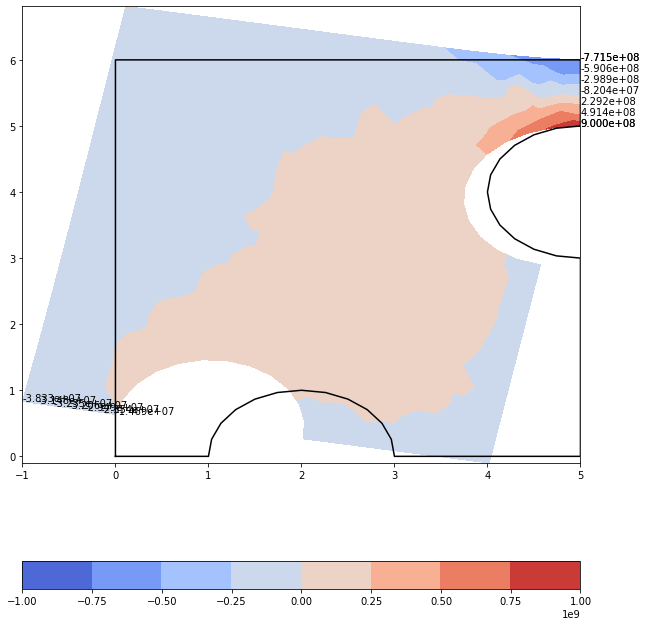

In [ ]:
# усиленно визуализируем результат
scale = 1 / np.max(np.abs(U))
aNodes = Nodes + scale * U.reshape(-1, 2)

plt.figure(figsize=(10, 12))
h = plt.tricontourf(*aNodes.T, Elems, SNmax_sign, cmap = 'coolwarm')
plt.plot(X, Y, color = 'black')

for i in range(int(nb/2) + 4*nb, 2*int(nb/2) + 4*nb + 1):
  plt.text(*aNodes[i], "{:.3e}".format(SNmax_sign[i]))
for i in range(0, int(nb/2) + 1):
  plt.text(*aNodes[i], "{:.3e}".format(SNmax_sign[i]))

[minNode] = aNodes[SNmax_sign == np.min(SNmax_sign[:, None])]
plt.text(*minNode, "{:.3e}".format(np.min(SNmax_sign[:, None])))

[maxNode] = aNodes[SNmax_sign == np.max(SNmax_sign[:, None])]
plt.text(*maxNode, "{:.3e}".format(np.max(SNmax_sign[:, None])))

plt.colorbar(h, orientation="horizontal")

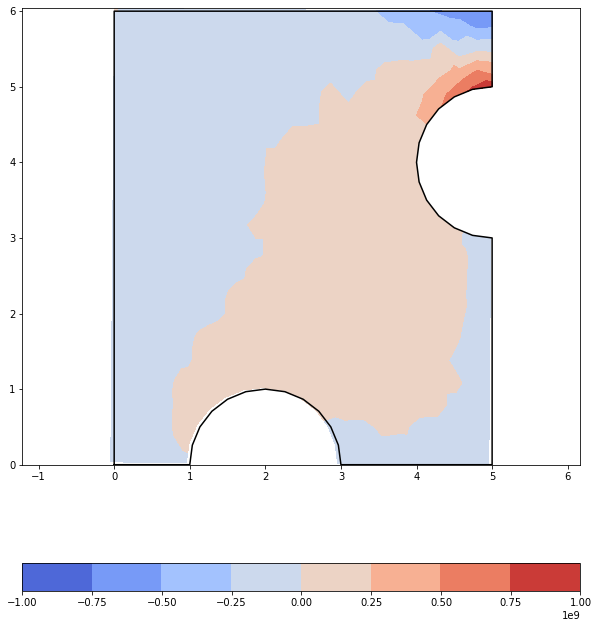

In [ ]:
# визуализируем результат
scale = 1
rNodes = Nodes + scale * U.reshape(-1, 2)

plt.figure(figsize=(10, 12))
h = plt.tricontourf(*rNodes.T, Elems, SNmax_sign, cmap = 'coolwarm')
plt.plot(X, Y, color = 'black')
plt.axis('equal')
    
plt.colorbar(h, orientation="horizontal")

In [ ]:
Umax = np.max(np.linalg.norm(U.reshape(-1, 2), axis = 1))
Umax

0.05829997681333529